In [1020]:
import pandas as pd
import numpy as np
from IPython.display import display
import plotly.graph_objects as go
from plotly.subplots import make_subplots
pd.options.plotting.backend = "plotly"

def generate_test_data():
    num_users = 20
    num_groups = 3
    num_repeat = 20

    dates = pd.date_range(start='2022-01-01', end='2022-01-31')
    total_num = dates.shape[0]*num_repeat
    usernames = [f'user-{num}' for num in (np.random.rand(total_num)*num_users).astype(int).tolist()]
    groups = [f'group-{num}' for num in (np.random.rand(total_num)*num_groups).astype(int).tolist()]

    base_df = pd.concat([pd.DataFrame(dates, columns=['timestamp']) for _ in range(num_repeat)]).reset_index(drop=True).assign(count=1)
    df = base_df.assign(
        username=usernames,
        group=groups,
    )
    return df.drop_duplicates()

df = generate_test_data()
df.head()

,timestamp,count,username,group
0,2022-01-01,1,user-0,group-0
1,2022-01-02,1,user-16,group-1
2,2022-01-03,1,user-7,group-0
3,2022-01-04,1,user-11,group-2
4,2022-01-05,1,user-14,group-2


In [1021]:
def create_matrix(df, add_column):
    return df.reset_index().pivot(index=['username', add_column], columns=['timestamp'], values=['count']).droplevel(axis=1, level=0).fillna(0)

def create_matrix_username_columns(df, add_column):
    return df.reset_index().pivot(index=['timestamp', add_column], columns=['username'], values=['count']).droplevel(axis=1, level=0).fillna(0)

def common_new_user(df, add_column):
    matrix_df = create_matrix(df, add_column)
    new_df = (matrix_df
              .idxmax(axis=1).to_frame(name='timestamp')
              .assign(count=1).reset_index()
              .pivot(index=['username', add_column], columns=['timestamp'], values='count')
              .sort_index().fillna(0)
             )
    return new_df

def get_new_user(df, add_column):
    return (
            common_new_user(df, add_column)
            .stack().to_frame(name='count').reset_index()
            .pivot(index=['timestamp', add_column], columns='username', values='count').sum(axis=1)
           )

def get_new_user_mask(df, add_column):
    return common_new_user(df, add_column).cumsum(axis=1).astype(bool)

def get_retained_user(df, add_column):
    matrix_df = create_matrix(df, add_column)
    return (
            ((matrix_df - matrix_df.shift(1, axis=1) == 0) & matrix_df.astype(bool))
            .stack().to_frame('count').reset_index()
            .pivot(index=['timestamp', add_column], columns='username', values='count').sum(axis=1)
    )

def get_resurrected_user(df, add_column):
    matrix_df = create_matrix(df, add_column)
    shifted_df = (matrix_df - matrix_df.shift(1, axis=1) == 1)
    not_new_user_df = ~common_new_user(df, add_column).astype(bool)
    left, right = shifted_df.align(not_new_user_df, axis=1, join='outer')
    return (
            (left & right.fillna(True))
            .stack().to_frame('count').reset_index()
            .pivot(index=['timestamp', add_column], columns='username', values='count').sum(axis=1)
    )

def get_churned_user(df, add_column):
    matrix_df = create_matrix(df, add_column)
    return (
            ((matrix_df - matrix_df.shift(1, axis=1) == -1) & ~matrix_df.astype(bool))
            .stack().to_frame('count').reset_index()
            .pivot(index=['timestamp', add_column], columns='username', values='count').sum(axis=1)
    )

def get_continuous_churned_user(df, add_column):
    matrix_df = create_matrix(df, add_column)
    return (
            ((matrix_df - matrix_df.shift(1, axis=1) == 0) & ~matrix_df.astype(bool))
            .stack().to_frame('count').reset_index()
            .pivot(index=['timestamp', add_column], columns='username', values='count').sum(axis=1)
    )

COL_GROUP = 'group'

# display(create_matrix(df, COL_GROUP).head())
# display(create_matrix_username_columns(df, COL_GROUP).head())
# display(get_new_user_mask(df, COL_GROUP).head())
# display(get_new_user(df, COL_GROUP).head())
# display(get_retained_user(df, COL_GROUP).head())
display(get_resurrected_user(df, COL_GROUP).head())
display(get_churned_user(df, COL_GROUP).head())
display(get_continuous_churned_user(df, COL_GROUP).head())

timestamp   group  
2022-01-01  group-0    0
            group-1    0
            group-2    0
2022-01-02  group-0    0
            group-1    0
dtype: int64

timestamp   group  
2022-01-01  group-0    0
            group-1    0
            group-2    0
2022-01-02  group-0    2
            group-1    6
dtype: int64

timestamp   group  
2022-01-01  group-0     0
            group-1     0
            group-2     0
2022-01-02  group-0    14
            group-1     5
dtype: int64

# Quick Ratio

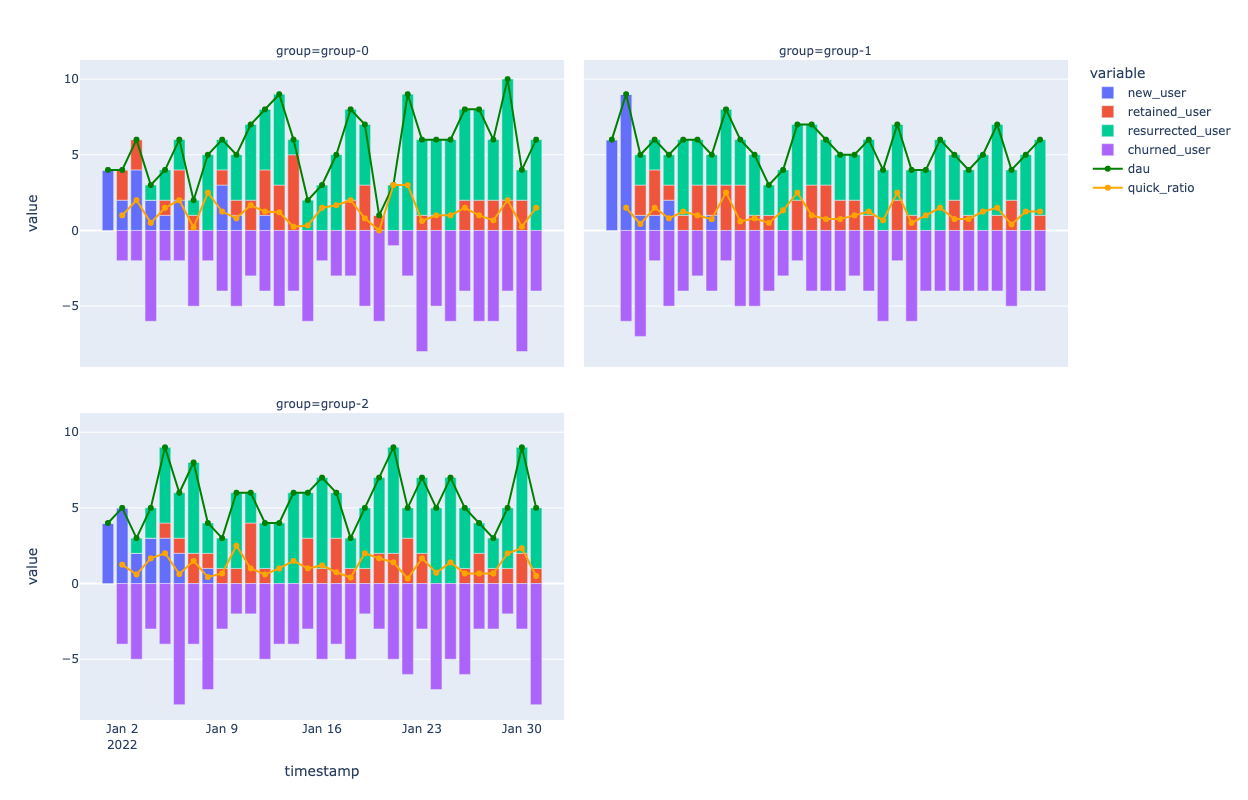

In [1046]:
new = create_matrix_username_columns(df, COL_GROUP).assign(
    dau=create_matrix_username_columns(df, COL_GROUP).sum(axis=1),
    new_user=get_new_user(df, COL_GROUP),
    retained_user=get_retained_user(df, COL_GROUP),
    churned_user=get_churned_user(df, COL_GROUP),
    continuous_churned_user=get_continuous_churned_user(df, COL_GROUP),
    resurrected_user=get_resurrected_user(df, COL_GROUP),
).fillna(0)

new['total'] = new.new_user + new.retained_user + new.resurrected_user + new.churned_user + new.continuous_churned_user
new['check'] = new.dau == new.new_user + new.retained_user + new.resurrected_user

## Plot
new['quick_ratio'] = (new.new_user + new.resurrected_user) / new.churned_user
new['churned_user'] = -new['churned_user']
new['continuous_churned_user'] = -new['continuous_churned_user']
# display(new[new.total != num_users])

# WebGL mode
fig_dau = go.Scattergl(
    x=new.index,
    y=new['dau'],
    name='dau',
    mode='lines+markers',
)

fig_quick_ratio = go.Scattergl(
    x=new.index,
    y=new['quick_ratio'],
    name='quick_ratio',
    mode='lines+markers',
)

facet_col_args = {'facet_col': 'group', 'facet_col_wrap': 2}
width_height = {'width': 1200, 'height': 800}
fig = px.bar(new.reset_index(), x='timestamp', y=['new_user', 'retained_user', 'resurrected_user', 'churned_user'], **facet_col_args)
fig_dau = (
    px.line(new.reset_index(), x='timestamp', y=['dau'], markers=True, **facet_col_args)
    .update_traces(line_color='green')
)
fig_quick_ratio = (
    px.line(new.reset_index(), x='timestamp', y=['quick_ratio'], markers=True, **facet_col_args)
    .update_traces(line_color='orange')
)
fig.add_traces(fig_dau.data)
fig.add_traces(fig_quick_ratio.data)
fig.update_layout(
    **width_height,
)
fig


# Other metrics TBD
* MAU / installation count
* new user / MAU
* DAU / MAU
* Dn / Mn / Wn metrics
* TBD
  * Lness
  * Cohort

In [978]:
def get_new_user_mau(df, freq='W-SUN'):
    return (
        pd.DataFrame(get_new_user(df)).reset_index().groupby(pd.Grouper(key='index', freq=freq)).sum()
        /
        pd.DataFrame(get_dau(df)).reset_index().groupby(pd.Grouper(key='index', freq=freq)).sum()
    )

get_new_user_mau(df).plot.bar()

def get_mau_installation(df, freq='W-SUN'):
    return (
        pd.DataFrame(get_dau(df)).reset_index().groupby(pd.Grouper(key='index', freq=freq)).sum().fillna(0)
        /
        pd.DataFrame(get_new_user(df)).reset_index().groupby(pd.Grouper(key='index', freq=freq)).sum().cumsum().fillna(0)
    )
    
get_mau_installation(df).plot()

def get_au1_au2(df, freq1, freq2):
    return (
        pd.DataFrame(get_dau(df)).reset_index().groupby(pd.Grouper(key='index', freq=freq1)).sum()
        /
        pd.DataFrame(get_dau(df)).reset_index().groupby(pd.Grouper(key='index', freq=freq2)).sum()
    ).dropna()

get_au1_au2(df, 'W', '4W').plot()

def get_dn_wn_mn_metrics(df, range_=[(1, 0), (7, 1), (28, 7), (84, 28), (84, 28), (364, 84)]):
    def app(x):
        first = x.idxmax()
        return (x.loc[first:].reset_index(drop=True))

    dn = df.T.apply(app, axis=1)    
    pairs = {f'd{pair[0]}_d{pair[1]}': ((dn.loc[:, pair[0]] == 1).sum() / (dn.loc[:, pair[1]] == 1).sum())
             for pair in range_ if dn.shape[1] > pair[0]}
    
    return pairs

get_dn_wn_mn_metrics(df, [(elem+1, elem) for elem in range(8)])

TypeError: get_new_user() missing 1 required positional argument: 'add_column'